In [1]:
from google.colab import drive

In [2]:
import pandas as pd

In [3]:
# mounting & permission
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# 데이터 파일 path 선언
colab_path = "gdrive/My Drive/AI Security Project/"

# 파일 로드 (양성데이터 1개, 공격트래픽데이터 10개)
benign=pd.read_csv(colab_path +'8.benign.csv')
g_c=pd.read_csv(colab_path +'8.gafgyt.combo.csv')
g_j=pd.read_csv(colab_path +'8.gafgyt.junk.csv')
g_s=pd.read_csv(colab_path +'8.gafgyt.scan.csv')
g_t=pd.read_csv(colab_path +'8.gafgyt.tcp.csv')
g_u=pd.read_csv(colab_path +'8.gafgyt.udp.csv')
m_a=pd.read_csv(colab_path +'8.mirai.ack.csv')
m_sc=pd.read_csv(colab_path +'8.mirai.scan.csv')
m_sy=pd.read_csv(colab_path +'8.mirai.syn.csv')
m_u=pd.read_csv(colab_path +'8.mirai.udp.csv')
m_u_p=pd.read_csv(colab_path +'8.mirai.udpplain.csv')

In [5]:
# 각 Data Set에 target Column 선언
benign['type']='benign'
g_c['type']='gafgyt_combo'
g_j['type']='gafgyt_junk'
g_s['type']='gafgyt_scan'
g_t['type']='gafgyt_tcp'
g_u['type']='gafgyt_udp'
m_u['type']='mirai_udp'
m_a['type']='mirai_ack'
m_sc['type']='mirai_scan'
m_sy['type']='mirai_syn'
m_u_p['type']='mirai_udpplain'

In [6]:
# Data Structure 훑어보기
benign.head()
benign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46585 entries, 0 to 46584
Columns: 116 entries, MI_dir_L5_weight to type
dtypes: float64(115), object(1)
memory usage: 41.2+ MB


In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# 열이 매우 많은 관계로 랜덤으로 열을 추출하여 데이터 탐색을 진행.
n = np.random.randint(0,116)
df = pd.DataFrame(benign.iloc[:,n]).describe()
col_name = df.columns[0]

print('현재 선택된 열의 이름 : {}'.format(col_name))
df.describe()

현재 선택된 열의 이름 : HpHp_L1_covariance


,HpHp_L1_covariance
count,8.000000e+00
mean,4.707487e+03
std,1.819194e+04
min,-1.643671e+04
25%,-9.225000e-84
50%,5.380050e+00
75%,1.966811e+03
max,4.658500e+04


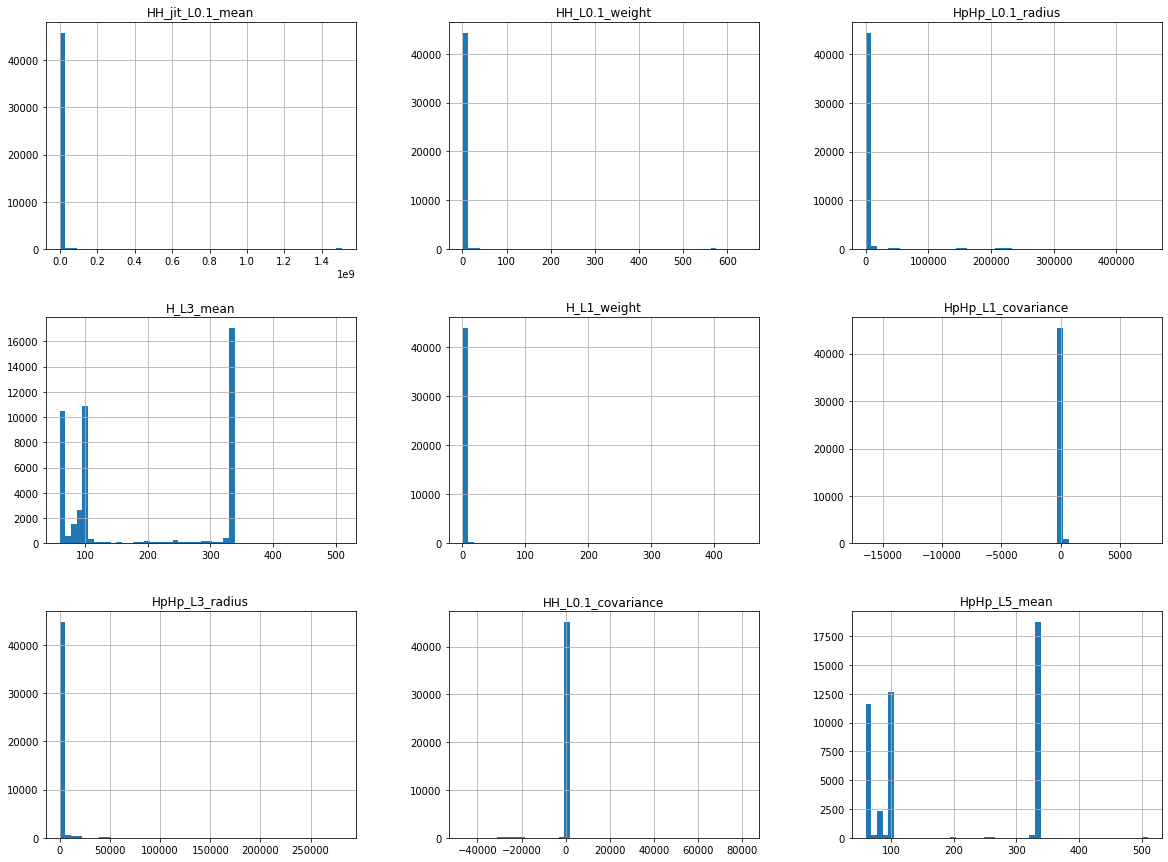

In [9]:
# 특성 각각의 히스토그램을 그려서, 특성 당 데이터 분포를 판단함.
## 판단 결과 -> 분포가 전체적으로 꼬리가 두껍고 모델이 학습하기에 적합하지 않다고 판단됨.
### 데이터 모델의 학습에 맞게 하기 위해서는 스케일링을 진행한다. (스케일링의 종류 : min-max scaling, standard scaling, log scaling)
rand_idx_list = np.random.randint(0,116, size=9)
benign_traffics = benign.iloc[:,rand_idx_list]

benign_traffics.hist(bins=50, figsize=(20,15))
plt.show()

In [10]:
from pandas.plotting import scatter_matrix

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb4a04ea050>,
      dtype=object)

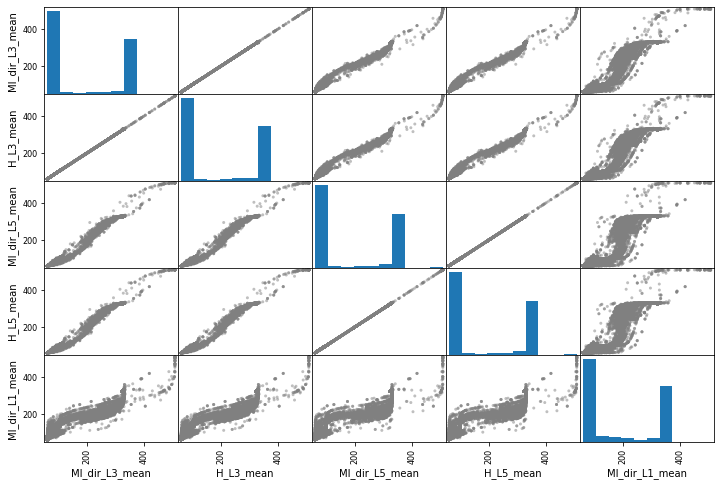

In [11]:
# 상관 관계 조사
## 특성 간의 상관 관계를 조사하기 위해서 산점도 분포를 확인함.
### 확인 결과, 특성간 상관 관계가 상당히 높아보임. 추가적인 분석이 필요하다고 판단됨
benign_corr_matrix = benign.corr()
corr_array = benign_corr_matrix['MI_dir_L3_mean'].sort_values(ascending=False)
high_corr_df = pd.DataFrame(corr_array).index[0:5]

scatter_matrix(benign[high_corr_df], 
               color = 'gray',
               figsize=(12,8))

Text(0, 0.5, 'H_L3_mean')

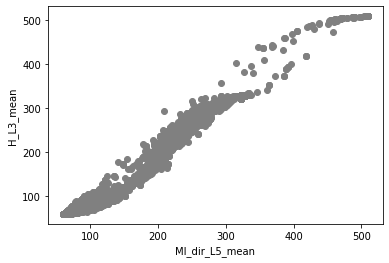

In [12]:
# MI_dir_L3_mean 특성과 임의의 특성 y를 골라 둘의 상관 관계를 비교하여 시각화함.
y = 'MI_dir_L5_mean'
plt.scatter(
    benign['MI_dir_L3_mean'], benign[y],
    color = 'gray'
            )
plt.xlabel(y)
plt.ylabel('H_L3_mean')

# Modeling

In [13]:
data_set=pd.concat([benign,m_u,g_c,g_j,g_s,g_t,g_u,m_a,m_sc,m_sy,m_u_p],
               axis=0, sort=False, ignore_index=True)

data_set.groupby('type')['type'].count()

type
benign             46585
gafgyt_combo       54283
gafgyt_junk        28579
gafgyt_scan        27825
gafgyt_tcp         88816
gafgyt_udp        103720
mirai_ack         111480
mirai_scan         45930
mirai_syn         125715
mirai_udp         151879
mirai_udpplain     78244
Name: type, dtype: int64

# 층화 추출?
층화추출이란, 모집단의 비율을 고려하여 데이터를 샘플링하는 것이다.

해당 프로젝트의 목적은 악성 트래픽을 Classification하는 것이므로, 본류의 고질적 문제인 클래스 분포 오류를 해결해야 한다.
만약, 남자, 여자를 임의로 뽑은 표본집단이 성비가 9:1, 8:2 라면, 이 샘플로 데이터를 학습시키면 당연히 오류가 날것이다. 따라서, 모집단의 비율에 맞게 샘플도 5:5 정도로 맞추어줘야 한다.

이렇게, 샘플의 비율을 모집단의 수에 맞게끔 하여 Train set과 Test set으로 나눠주는 것이 Stratified Shuffle Split(층화추출)이다.

전체 데이터 셋에서 mirai_udp의 비율은 0.17이다.
그래서, 이를 층화추출로 뽑은 train_set에서도 mirai_udp 비율은 0.17로 유지되고,
test_set에서도 0.17로 유지된다.

In [14]:
# 분류의 고질적 문제인 클래스 불균형 해소를 위해 층화추출을 시도하여 학습을 시킨다.
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data_set, data_set['type']):
  strat_train_set = data_set.loc[train_index]
  strat_test_set = data_set.loc[test_index]

# 층화 추출 여부 확인 (클래스 비율이 유지된 샘플이 추출되었는지를 확인하는 과정)
print(strat_train_set['type'].value_counts()/len(strat_train_set), '\n')
print(strat_test_set['type'].value_counts()/len(strat_test_set))

mirai_udp         0.175978
mirai_syn         0.145663
mirai_ack         0.129169
gafgyt_udp        0.120178
gafgyt_tcp        0.102909
mirai_udpplain    0.090659
gafgyt_combo      0.062896
benign            0.053977
mirai_scan        0.053218
gafgyt_junk       0.033113
gafgyt_scan       0.032240
Name: type, dtype: float64 

mirai_udp         0.175978
mirai_syn         0.145662
mirai_ack         0.129168
gafgyt_udp        0.120177
gafgyt_tcp        0.102907
mirai_udpplain    0.090660
gafgyt_combo      0.062898
benign            0.053977
mirai_scan        0.053218
gafgyt_junk       0.033115
gafgyt_scan       0.032240
Name: type, dtype: float64


# Scaling

In [38]:
# target data 선언
train_y = strat_train_set['type']
test_y = strat_test_set['type']

# MinMax Scaling의 선택 이유
해당 모델은 이상 트래픽을 탐색하여 위협 종류를 분류하는 모델이므로, 이상치를 전처리할 필요가 없다.
그래서, 이상치에 영향을 크게 받지 않는 Standard Scaling보다는 Min-Max scaling이 더 적절한 방식이라고 판단됐다.

In [16]:
# pipeline 구축을 통한 scaling 진행
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

cat_col = ['type']
num_col = strat_train_set.drop('type', axis=1).columns

num_pipeline = Pipeline([
    ('std_scaler', MinMaxScaler())
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_col)
])

data_scaled = full_pipeline.fit_transform(strat_train_set)
test_scaled = full_pipeline.transform(strat_test_set)

# PCA 진행

현재 데이터셋에서 feature의 수가 무려 115개나 된다는 점이 우려되었다. (차원의 저주 우려)
또한, 원본 데이터에 대한 아무런 조치 없이 학습을 시켰을 때 시간이 너무 많이 들어갔다는 점이 분류 전 PCA를 진행한 주된 이유이다.

PCA는 쉽게 말해 가장 인기 있는 차원 축소 알고리즘이다.
말 그대로 115개의 차원(Feature)을 숫자를 줄여 저차원으로 만드는 것이다.
당연히, 차원을 줄이는 것이기에 데이터의 품질은 떨어질 수 있다.
차원의 수를 많이 줄일수록 품질은 더욱 떨어진다.

여기서 품질에 대한 지표가 '설명된 분산'이다.
차원의 수를 줄이면 설명된 분산은 줄어든다.
그래서, 차원의 수와 설명된 분산의 그래프를 그려, 어느 지점에서 최적의 차원을 설정하는지 알 수 있다.

아래의 그래프를 참고하면 알 수 있듯이,
차원의 수와 설명된 분산에 대한 그래프는 elbow가 존재한다.
차원을 올릴수록 급격하게 설명된 분산의 정도가 올라가다가 어느 지점부터 차원의 수를 늘리는 것에 비해 분산 정도는 크게 오르지 않는다. 그래서, 최적 지점을 특별히 정의할 수 있고,
일반적인 경우 설명된 분산을 0.95로 갖는 차원의 수를 선택한다.

In [19]:
# PCA 알고리즘 선택과 최적 차원 수 탐색
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95) # 분산 기준은 0.95로 설정함
data_prepared = pca.fit_transform(data_scaled)
test_prepared = pca.transform(test_scaled)
print(data_prepared.shape) # 몇 차원으로 줄였는지 확인해본 결과 115개의 feature를 6개의 차원으로 줄였음을 확인할 수 있었음.

(690444, 6)


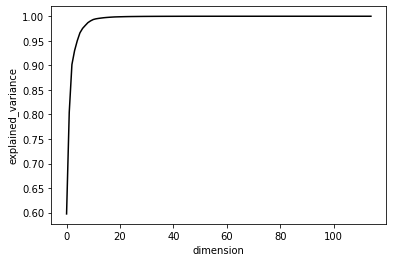

In [20]:
# 차원 수 시각화를 위한 임의의 pca 선언
pca_test = PCA()
pca_test.fit(data_scaled) # 차원에 따른 설명된 분산 및 elbow 파악을 위하여 선언함.
cumsum = np.cumsum(pca_test.explained_variance_ratio_)

# 차원수와 분산 상관관계 시각화
cumsum = pd.DataFrame(cumsum)

cumsum.plot(xlabel='dimension', 
            ylabel='explained_variance',
            color = 'black',
            legend = None,
            )

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb48fc3c450>,
      dtype=object)

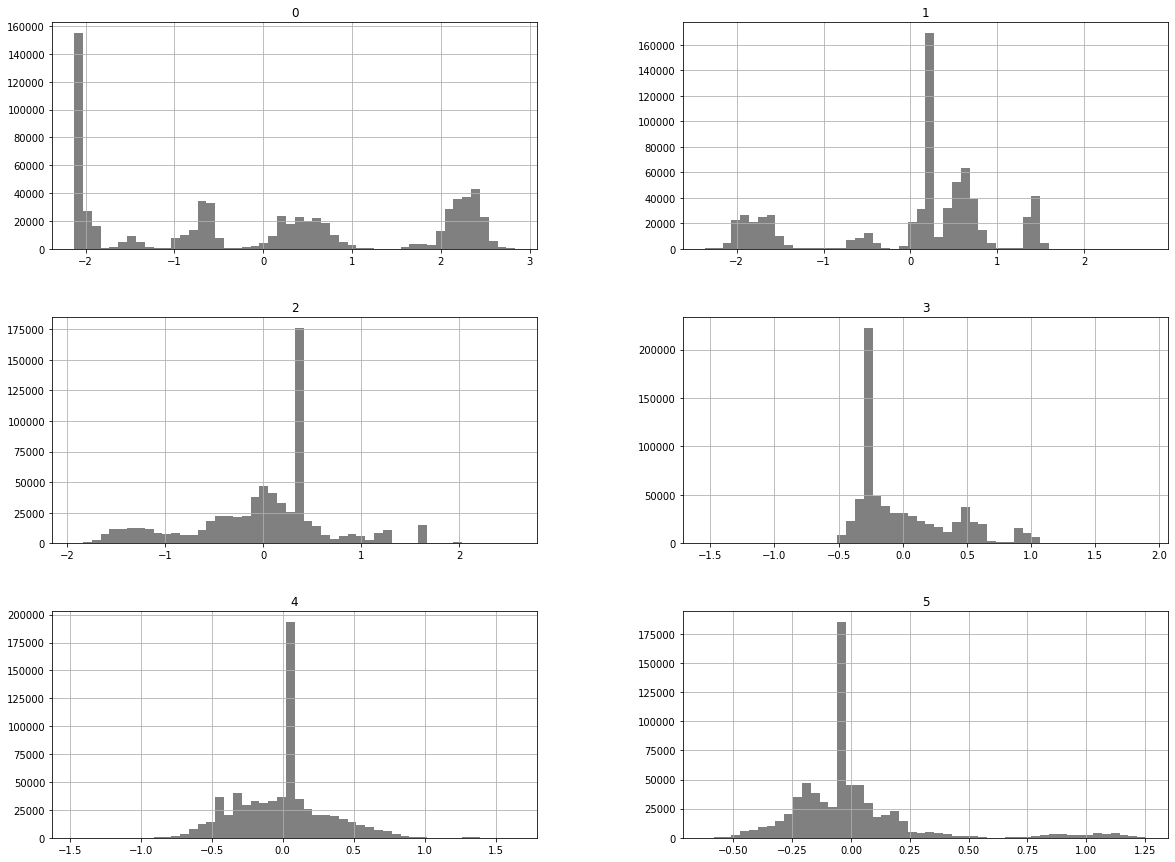

In [21]:
# MinMax-Scaling ,PCA를 진행한 이후 각 Feature의 히스토그램
## 스케일링 이전보다 분포가 학습하기 좋은 형태로 그려졌다고 판단됨.

pd.DataFrame(data_prepared).hist(bins=50, figsize=(20,15), color = 'gray')

# Modeling

In [22]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [23]:
# KNN 학습
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(data_prepared, train_y)
train_score = knn.score(data_prepared, train_y)
test_score = knn.score(test_prepared, test_y)

In [24]:
# KNN 성능 평가
f1_scores = f1_score(test_y, knn.predict(test_prepared), average='weighted')
ps = precision_score(test_y, knn.predict(test_prepared), average='weighted')
rs = recall_score(test_y, knn.predict(test_prepared), average='weighted')

print("Train Score : ", train_score)
print("Test Score:", test_score)
print("F1 score : ", f1_scores)
print("precision_score : ", ps)
print("recall_score : ", rs)

Train Score :  0.999061473486626
Test Score: 0.9982677913470674
F1 score :  0.9982665595718342
precision_score :  0.9982665161316379
recall_score :  0.9982677913470674


In [25]:
# SGD Classifier 학습
from sklearn.linear_model import SGDClassifier
gbf = SGDClassifier()
gbf.fit(data_prepared, train_y)
train_score = gbf.score(data_prepared, train_y)
test_score = gbf.score(test_prepared, test_y)

In [26]:
# SGD Classifier 성능 평가
f1_scores = f1_score(test_y, gbf.predict(test_prepared), average='weighted')
ps = precision_score(test_y, gbf.predict(test_prepared), average='weighted')
rs = recall_score(test_y, gbf.predict(test_prepared), average='weighted')

print("Train Score : ", train_score)
print("Test Score:", test_score)
print("F1 score : ", f1_scores)
print("precision_score : ", ps)
print("recall_score : ", rs)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Score :  0.7820214238953485
Test Score: 0.7826744374666883
F1 score :  0.7450521321135231
precision_score :  0.7308624365163614
recall_score :  0.7826744374666883
